## TEM image analysis
___
Determine particle diameters of gold and silver nanoparticles used in these experiments from TEM images.

This analysis uses python packages, scipy, numpy, scikit-image to analyze the images and matplotlib to visualize the data.

In [12]:
# Load modules

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.filters import sobel, threshold_otsu
from skimage.color import rgb2gray, label2rgb
from skimage import data,io,filters,measure,img_as_ubyte, segmentation, morphology

from scipy.ndimage import gaussian_filter
from scipy.stats import mode

from skimage import img_as_float
from skimage.morphology import reconstruction

from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import os

%matplotlib inline

### Step 1. Read in data from tif files, convert from RGB to gray scale and remove the 4 pixel border.
Conversion from 8-bit RGB tiff to 8-bit grayscale tiff requires an intermediate step of converting the image to a floating point format. 

Note: this will raise a warning about loss of precision however that is not a concern here since we are only interested in morphology so preservation of precision is not critical. The user warning is temporarily suppressed.

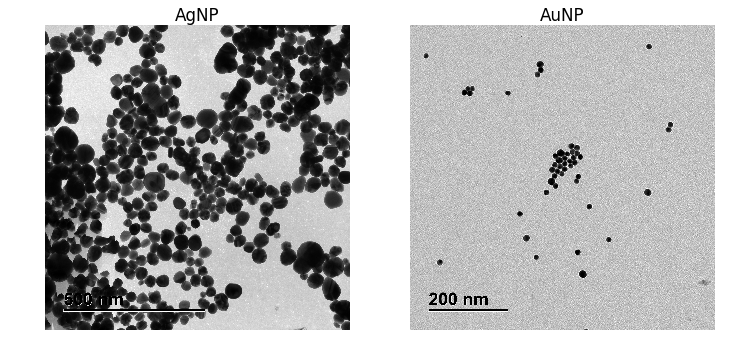

In [13]:
import warnings

def supprwarn():
    warnings.warn("user", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    supprwarn()

    origfull = io.imread('../Data/AgNP-12.tif')
    orig = origfull[4:-4,4:-4]
    imggray = img_as_ubyte(rgb2gray(orig))
    
    aufull = io.imread('../Data/AuNP-07.tif')
    origau = aufull[4:-4,4:-4]
    augray = img_as_ubyte(rgb2gray(origau))

plt.rc('font', size='14')
    
fig, axes = plt.subplots(1, 2, figsize=(12,6))
for img,a,title in zip((imggray,augray),axes,['AgNP','AuNP']):
    a.axis('off')
    a.set_title(title)
    a.imshow(img, cmap='gray')

### Step 2. Reduce background noise.
Invert the grayscale image so that the nanoparticles become regional maxima then apply the <i>h-dome</i> technique; (1) the image is subtracted by some threshold value <i>h</i> that is intended to isolate the maxima, (2) the resulting image is dilated, (3) the dilated image is subtracted from the original.

In the following steps, the AgNP image loaded above will be used to demonstrate the analysis procedure.


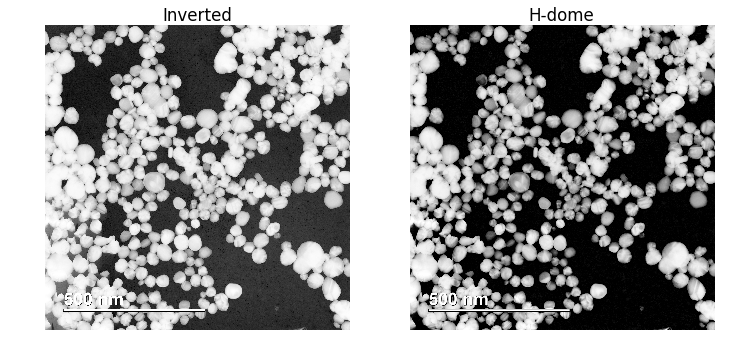

In [16]:
# Invert grayscale image to convert NPs to local maxima
imginv = np.copy(imggray)
# Converting this 16-bit image
imginv = np.invert(imginv)

# scipy gaussian filter requires floating point data
imggaus = img_as_float(imginv)
imggaus = gaussian_filter(imggaus, 1)

h = 0.5
seed = imggaus - h
mask = imggaus

dilated = reconstruction(seed, mask, method='dilation')

imghdome = imggaus - dilated

# otsu = threshold_otsu(imginv)
# imgotsu = imginv > otsu
# # imgotsuinv = np.invert(imgotsu)

# print("Otsu threshold:", otsu)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.axis('off')
ax1.set_title('Inverted')
ax1.imshow(imginv, cmap='gray')
ax2.axis('off')
ax2.set_title('H-dome')
ax2.imshow(imghdome, cmap='gray')

### Step 3. Apply Laplacian of Gaussian blob detection to identify NPs.

Calculating nanoparticle diameter is severly hampered by the overlapping that occurs during the evaporation step of sample preparation. Using a thresholding-approach will end up creating poorly-outlined nanoparticles that are difficult to isolate and measure. A region or edge-based segmentation approach also suffers from problems identifying these particles that are not well differentiated.

An alternative approach is to employ blob detection, a computer vision techniques used to identify regions within an image based on brightness or color. Here, the NPs have a strong contrast against the background of the TEM grid as the particles have a roughly spherical shape. In addition to identification of blobs (i.e., nanoparticles) the method will also give an estimate of the size of the blob.

In test runs, the LoP technique seemed to do a better job of identifying nanoparticles than the difference of Gaussian (DoG) and determinant of hessian (DoH). This is to be expected as LoP is known to be the slowest but most accurate of the three.

In [17]:
# Using the dilated grayscale image to better identify local maxima (i.e., particles)
# This technique is designed to reduce false positives due to background noise,
# by isolating the local maxima

image = imghdome

kwargs = {}
kwargs['min_sigma'] = 25
kwargs['max_sigma'] = 50
kwargs['num_sigma'] = 25
kwargs['threshold'] = 0.01
kwargs['overlap'] = 0.4

# Using the laplacian of gaussians seems to work better than other blob detection schemes
blobsh = blob_log(image, **kwargs)
# Convert gaussian sigma values to blob radii
blobsh[:, 2] = blobsh[:, 2] * sqrt(2)


Number of identified particles: 313



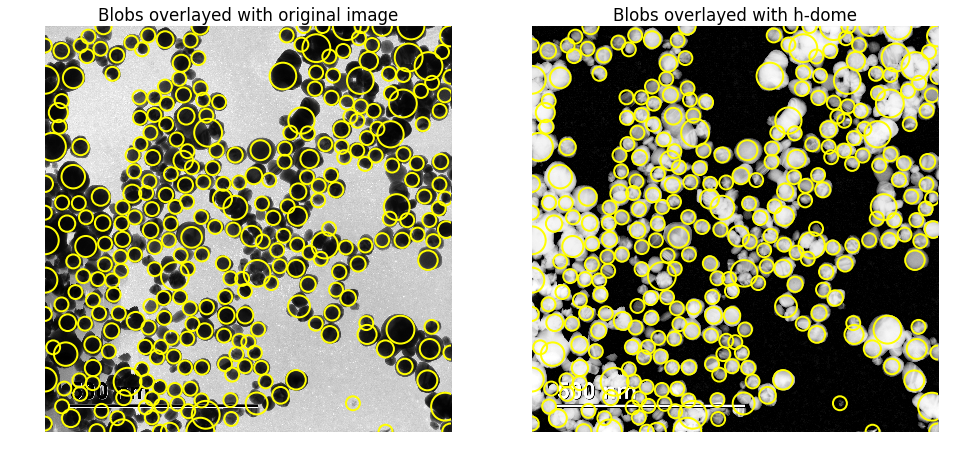

In [18]:
print('')
print('Number of identified particles:', blobsh.shape[0])
print('')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.axis('off')
ax1.set_title('Blobs overlayed with original image')
ax1.imshow(imggray, cmap='gray')
for blob in blobsh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax1.add_patch(c)

ax2.axis('off')
ax2.set_title('Blobs overlayed with h-dome')
ax2.imshow(imghdome, cmap='gray')
for blob in blobsh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax2.add_patch(c)

#### Improvements with h-dome

Obviously from the above images, there are a few misidentifications but overall the blobs seem to coincide with the expected outlines of the nanoparticles. Also,  blob detection assumes a perfect spheroidal shape while the NPs seem to be slightly prolate.

Below is a quick comparison showing the results without using the h-dome computation. There are a few clear false positives coming from the background (TEM grid).

In [19]:
# Using the non-dilated inverted grayscale image

image = imginv

blobsnon = blob_log(image, **kwargs)
# Convert gaussian sigma values to blob radii
blobsnon[:, 2] = blobsnon[:, 2] * sqrt(2)


Number of identified particles: 322



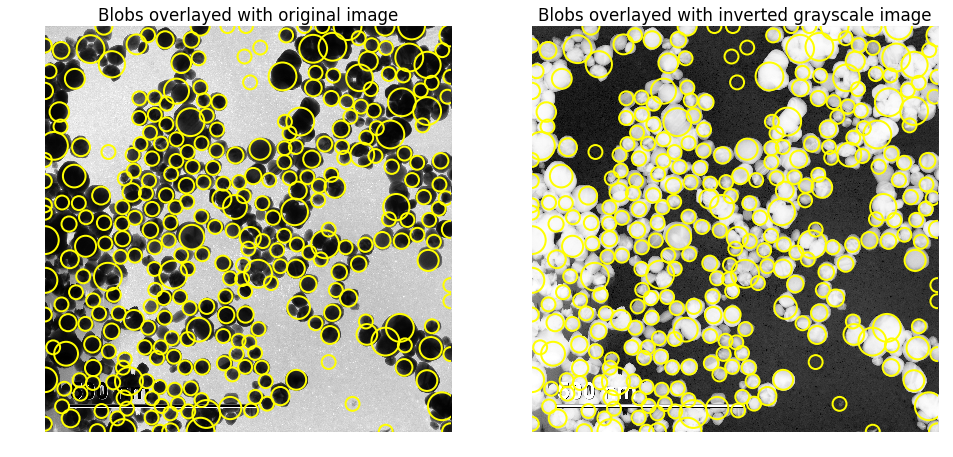

In [20]:
print('')
print('Number of identified particles:', blobsnon.shape[0])
print('')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.axis('off')
ax1.set_title('Blobs overlayed with original image')
ax1.imshow(imggray, cmap='gray')
for blob in blobsnon:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax1.add_patch(c)

ax2.axis('off')
ax2.set_title('Blobs overlayed with inverted grayscale image')
ax2.imshow(imginv, cmap='gray')
for blob in blobsnon:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax2.add_patch(c)

### Step 4. Compute nanoparticle diameters.

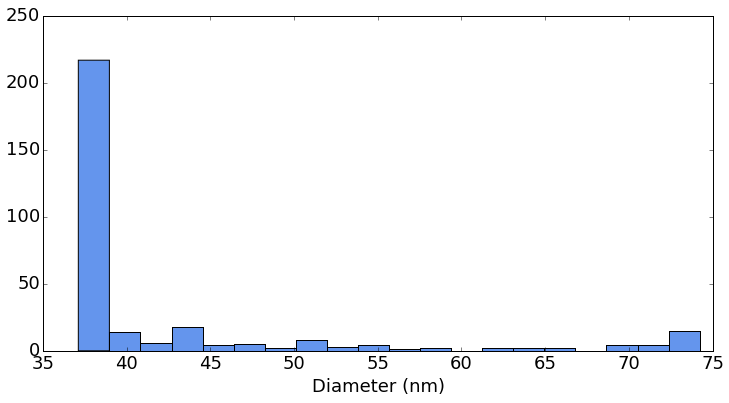

In [25]:
blobs = blobsh

dia = 2*blobs[:,-1]

# Pixel calibration 969-26 pixels is 500nm from ImageJ plot profile of line segment across scale bar
npdia = dia*500/(969-26)
# nparea = np.pi*np.power(npdia/2, 2)

plt.rc('font', size='18')

fig, ax1 = plt.subplots(1,1, figsize=(12,6))
ax1.set_xlabel('Diameter (nm)')
_, _, _ = ax1.hist(npdia, bins=20, color='CornflowerBlue')

### Step 5. Repeat for all other images.

In [26]:
rdir = '/Volumes/TRANSFER/TEM/2015-10-15 - AuNP and AgNP/'
# files = os.listdir(rdir)
# Sort out non images '*.tif'
# srtfiles = [f for f in files if '.tif' in f]

# Not all files are useful due to shifting magnification scales, must manually input
srtfiles = ['AgNP-01.tif','AgNP-02.tif','AgNP-03.tif','AgNP-04.tif','AgNP-05.tif','AgNP-06.tif']
srtfiles.extend(['AgNP-07.tif','AgNP-11.tif','AgNP-12.tif'])
srtfiles.extend(['AuNP-02.tif','AuNP-03.tif','AuNP-05.tif','AuNP-06.tif','AuNP-07.tif','AuNP-08.tif'])
srtfiles.extend(['AuNP-09.tif','AuNP-10.tif'])

def temblob(filename):
    
    orgfull = io.imread(rdir+filename)
    org = orgfull[4:-4,4:-4]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        supprwarn()
    
        igray = img_as_ubyte(rgb2gray(org))
        iinv = np.invert(igray)

    igaus = img_as_float(iinv)
    igaus = gaussian_filter(igaus, 1)
    h = 0.5
    sd = igaus - h
    msk = igaus
    dilat = reconstruction(sd, msk, method='dilation')
    hdome = igaus - dilat
    
    blobs = blob_log(hdome, **kwargs)
    diam = 2*sqrt(2)*blobs[:,-1]

#     Convert to particle diameters based scale bar included in image
    if 'Ag' in filename:
        npdiam = diam*500/(969-26)
    elif 'Au' in filename:
        npdiam = diam*200/(777-23)
    else:
        raise Exception('Unable to parse filename.')
    
    return(npdiam)
    
    
audia = []
agdia = []
for file in srtfiles:
    sgldia = temblob(file)
    if 'Ag' in file:
        agdia.extend(sgldia.tolist())
    elif 'Au' in file:
        audia.extend(sgldia.tolist())
    else:
        raise Exception('Unable to parse filename.')

### Step 6. Compile results.
Visualize distribution of nanoparticles with hisgtogram and use pandas to prepare a table of values for each nanoparticle type.

Again note that there are likely a few false positives included these results. However steps were taken to minimize their influence.

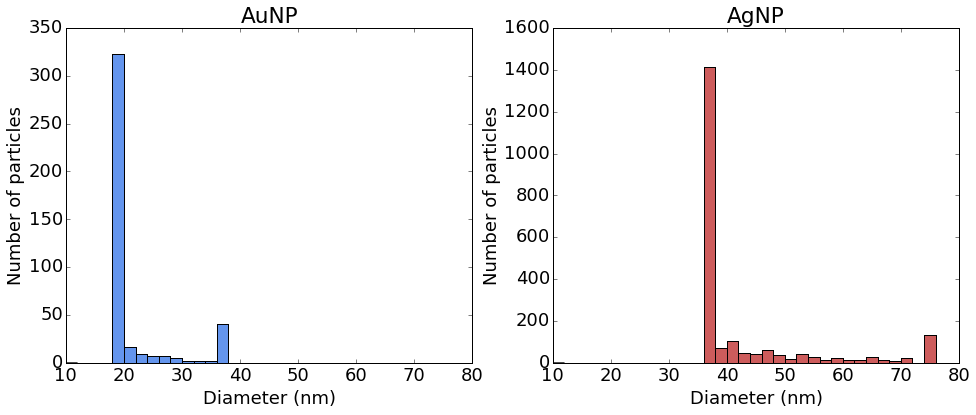

In [27]:
plt.rc('font', size='18')

bins = range(10,80,2)

fig, axes = plt.subplots(1,2, figsize=(16,6))
for a,title,sample,color in zip(axes, ('AuNP','AgNP') ,(audia, agdia),('CornflowerBlue','IndianRed')):
    a.set_xlabel('Diameter (nm)')
    a.set_ylabel('Number of particles')
    a.set_title(title)
    _, _, _ = a.hist(sample, bins=bins, color=color)

In [28]:
# Statistical report

dfinal = pd.DataFrame([[len(audia)],[len(agdia)]], columns=['Total particles counted'], index=['AuNP','AgNP'])
dfinal['Mean Diameter (nm)'] = np.round([np.mean(audia),np.mean(agdia)],1)
dfinal['Median Diameter (nm)'] = np.round([np.median(audia),np.median(agdia)],1)
dfinal['Mode Diameter (nm)'] = np.round([mode(audia)[0],mode(agdia)[0]],1)

dfinal

,Total particles counted,Mean Diameter (nm),Median Diameter (nm),Mode Diameter (nm)
AuNP,414,21.4,18.8,18.8
AgNP,2125,43.1,37.5,37.5
